# import libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

# dir & file access
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2.2.0-rc3


# define helper functions 

In [0]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('time')
  plt.ylabel(metric)
  plt.grid(True)

# get data

In [0]:
%%capture
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

In [0]:
# unzip dataset= !unzip file_path -d target_path

# !unzip '/tmp/horse-or-human.zip' -d '/tmp/horse-or-human'
# !unzip '/tmp/validation-horse-or-human.zip' -d '/tmp/validation-horse-or-human'

In [0]:
# define dir

base_dir = os.path.join('tmp')
train_dir = os.path.join(base_dir, 'horse-or-human')
validation_dir = os.path.join(base_dir, 'validation-horse-or-human')

# data preprocessing

ImageGenerator is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. 

---
`example:` 

you will have a 'training' directory containing a 'horses' directory and a 'humans' one. 
- ImageGenerator will label the images appropriately for you, reducing a coding step. 


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range 
  # (originally all values are in the `[0, 255]` range).
train_data_generator = ImageDataGenerator(
    rescale=1./255, # normalize
    rotation_range=40, # randomly rotate (0-180 degrees)
    width_shift_range=0.2, # move img horizontally within frame
    height_shift_range=0.2, # move img vertically within frame
    shear_range=0.2, # transform img to cut out sections (0.2=20%)
    zoom_range=0.2, # magnify % of img
    horizontal_flip=True, # randomly make multiple imgs structurally similar
    fill_mode='nearest' # fill in lost pixels via transformation. 
)
validation_data_generator = ImageDataGenerator(
    rotation_range=40, # randomly rotate (0-180 degrees)
    width_shift_range=0.2, # move img horizontally within frame
    height_shift_range=0.2, # move img vertically within frame
    shear_range=0.2, # transform img to cut out sections (0.2=20%)
    zoom_range=0.2, # magnify % of img
    horizontal_flip=True, # randomly make multiple imgs structurally similar
    fill_mode='nearest' # fill in lost pixels via transformation. 
)


In [0]:
# flow the imgs from source dir through data generator to preprocess in batches
train_generator = train_data_generator.flow_from_directory(
  '/tmp/horse-or-human', # source directory
  target_size=(300, 300), # standardize img dimensions(height, width)
  batch_size=128, # process in batches of 128
  class_mode='binary' # prediction type
)

# flow the validation imgs from source dir through the generator to preprocess in batches
validation_generator = validation_data_generator.flow_from_directory(
  '/tmp/validation-horse-or-human',
  target_size=(300, 300),
  batch_size=32,
  class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# define the model

In [0]:
model = tf.keras.Sequential([
  # keras model_shape= (batches, height, width, color_channel)
  # input_layer needs to match target_size of ImageDataGenerator
  # 32 3x3 filters/neurons filterning for unique shared features
  # relu: return if x > 0, else return 0
  # output_shape= since convoluton needs 3x3 full matrix, removes 1 from each side
    # output_shape=(None, 148, 148, 32 neurons)
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(300, 300, 3)),
  # maxPooling layer condenses feature maps by striding a 2x2 filter to id most prominent features
  # output_shape= maxPooling halves pixels
    # output_shape=(None, 74, 74, 32)
  tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
  # add additonal convolutions & maxPooling to filter for more granular shared features
  # output_shape=(None, 72, 72, 32)
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  # output_shape=(None, 36, 36, 32)
  tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
  # output_shape=(None, 34, 34, 128)
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
  # output_shape=(None, 17, 17, 128)
  tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
  tf.keras.layers.Dropout(.2),
  # flatten vector into a 1D array for dense processing
  # output_shape=(None, 36992)
    # 36992 pixels = 17 x 17 x 128
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(.2),
  # fully-connected dense layers map inputs to outputs
  # output_shape=(None, 512)
  tf.keras.layers.Dense(units=512, activation='relu'),
  # output layer needs to just predict 1
  # sigmoid good for binary classification 
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Total params: weights + hyperparameters
# Trainable params: weights
# Non-trainable params: hyperparameters
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 149, 149, 64)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 147, 147, 32)      18464     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 71, 71, 128)      

# compile the model

build the modely by compiling it with a loss, optimizer, and objective metric
- an optimizer charts the prediction performance via gradient descent and adjusts it in relation to the loss to maximize it.
- the loss is the prediction accuracy. 

since this is a binary classification problem (0 or 1) indicated by the output layer activation function sigmoid, the loss should be binary_crossentropy. 

In [0]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

# define callbacks

In [0]:
# enable early stopping to prevent overfitting
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('acc') > .95:
      print('\nStopping training')
      self.model.stop_training = True

# instantiate model
callbacks = myCallback()

# train the model

fit the model to train & learn the relationships

assign trained model to history var for model querying

In [0]:
history = model.fit(
    train_generator, # preprocessed dataset
    steps_per_epoch=8, # 1027 train imgs = batch_size(32) * steps(8)
    epochs=15,
    validation_data=validation_generator,
    validation_steps=8,# 256 test imgs = batch_size(32) * steps(8)
    # callsbacks=[callbacks],
    verbose=1
)

Epoch 1/15
8/8 [==============================] - 25s 3s/step - loss: 0.7256 - accuracy: 0.5410 - val_loss: 17.7455 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 27s 3s/step - loss: 0.6857 - accuracy: 0.5395 - val_loss: 15.0386 - val_accuracy: 0.4844
Epoch 3/15
8/8 [==============================] - 25s 3s/step - loss: 0.7038 - accuracy: 0.5595 - val_loss: 20.3835 - val_accuracy: 0.4961
Epoch 4/15
8/8 [==============================] - 25s 3s/step - loss: 0.6778 - accuracy: 0.5762 - val_loss: 38.8670 - val_accuracy: 0.5156
Epoch 5/15
8/8 [==============================] - 25s 3s/step - loss: 0.7550 - accuracy: 0.5306 - val_loss: 10.0434 - val_accuracy: 0.4648
Epoch 6/15
8/8 [==============================] - 25s 3s/step - loss: 0.6855 - accuracy: 0.6118 - val_loss: 19.8663 - val_accuracy: 0.4922
Epoch 7/15
8/8 [==============================] - 24s 3s/step - loss: 0.6693 - accuracy: 0.5729 - val_loss: 21.4517 - val_accuracy: 0.4961
Epoch 8/15
8/8 [===========

# visualize performance

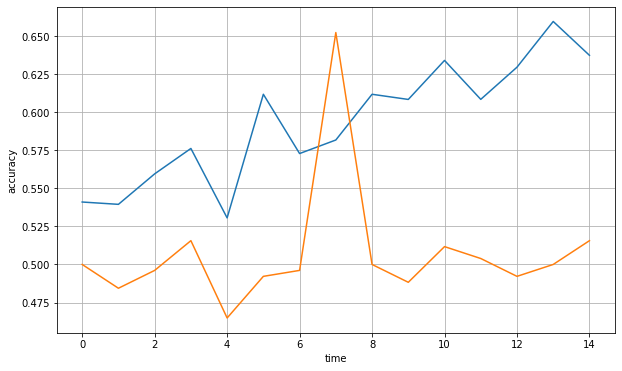

In [0]:
plt.figure(figsize=(10,6))
plot_graphs(history, 'accuracy')
plt.show()

# test model

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
 

# clean up

In [0]:
import os, signal

# os.kill(os.getpid(), signal.SIGKILL)